In [201]:
from dataclasses import dataclass
import numpy as np 
from typing import Iterable, Optional, Mapping, Literal

Replicate = int
Peptide = int
Pool = int
SwapCandidateList = Iterable[tuple[Replicate, Pool, Peptide]]
ReplicateToNeighborDict = Mapping[Replicate, Mapping[Peptide, set[Peptide]]]
PeptidePairList = Iterable[tuple[Peptide, Peptide]]

@dataclass
class Spec:
    num_peptides : int
    max_peptides_per_pool : int
    num_replicates : int
    invalid_neighbors : PeptidePairList
    preferred_neighbors : PeptidePairList

@dataclass
class Solution(Spec):
    assignments : Mapping[Replicate, Mapping[Pool, Iterable[Peptide]]]
    
    def move_peptide(self, replicate_idx : Replicate, old_pool_idx : Pool, peptide : Peptide, new_pool_idx : Pool):
        """
        Move a peptide from its current pool to a new pool
        """
        pool_to_peptides = self.assignments[replicate_idx]
        old_pool = pool_to_peptides[old_pool_idx]
        new_pool = pool_to_peptides[new_pool_idx]
        assert len(new_pool) < self.max_peptides_per_pool
        pool_to_peptides[new_pool_idx] = np.array(list(new_pool) + [peptide])
        
        pool_to_peptides[old_pool_idx] = np.array([p for p in old_pool if p != peptide])
    
    def swap_peptides(
            self, replicate_idx : Replicate, 
            pool_idx_a : Pool, 
            peptide_a : Peptide, 
            pool_idx_b : Pool, 
            peptide_b : Peptide):
        """
        Move peptide A from its current pool to the pool of peptide B (and vice versa)
        """
        pool_to_peptides = self.assignments[replicate_idx]
        pool_a = pool_to_peptides[pool_idx_a]
        pool_b = pool_to_peptides[pool_idx_b]
        pool_to_peptides[pool_idx_a] = np.array([i for i in pool_a if i != peptide_a] + [peptide_b])
        pool_to_peptides[pool_idx_b] = np.array([i for i in pool_b if i != peptide_b] + [peptide_a])

        
    def remove_empty_pools(self):
        """
        Delete any empty pools and renumber the pools to be contiguous
        """
        for (replicate_idx, pool_to_peptides) in self.assignments.items():
            to_delete = [pool_idx for (pool_idx, pool) in pool_to_peptides.items() if len(pool) == 0]
            if len(to_delete) > 0:
                for pool_idx in to_delete:
                    del pool_to_peptides[pool_idx]
                index_mapping = {
                    old_idx: new_idx 
                    for (new_idx, old_idx) 
                    in enumerate(sorted(pool_to_peptides.keys()))
                }
                self.assignments[replicate_idx] = {
                    index_mapping[pool_idx]: pool
                    for (pool_idx, pool) in pool_to_peptides.items()
                }
                
    def num_pools(self):
        total = 0
        for pool_to_peptides in self.assignments.values():
            total += len(pool_to_peptides)
        return total 
    
    def average_peptides_per_pool(self):
        return self.num_peptides * self.num_replicates / self.num_pools()
    

In [ ]:
from collections import defaultdict

def violations_per_replicate(
        s : Solution,
        error_on_duplicate=True,
        error_on_extra=True,
        error_on_missing=True,
        verbose=False) -> Mapping[Replicate, int]:
    replicate_to_violations = {}
    
    # treat invalid pairs as if they've already been neighbors in a previous round
    peptide_to_neighbors = pairs_to_dict(s.invalid_neighbors)
  
    for replicate_idx, pool_to_peptides in s.assignments.items():
        violations = 0
        replicate_num = replicate_idx + 1
        
        # first check each peptide occurs once per replicate
        seen_peptides = set()
        for peptides in pool_to_peptides.values():
            for p in peptides:
                if p in seen_peptides:
                    if error_on_duplicate:
                        raise ValueError("Peptide %s twice in replicate %s" % (p, replicate_num))
                    violations += 1
                seen_peptides.add(p)
        expected_peptides = set(range(s.num_peptides))
        if seen_peptides != expected_peptides:
            extra_peptides = seen_peptides.difference(expected_peptides)
            if extra_peptides:
                if error_on_extra:
                    raise ValueError("Unexpected extra peptides in replicate %d: %s" % (replicate_num, extra_peptides,))
                violations += len(extra_peptides)
            missing_peptides = expected_peptides.difference(seen_peptides)
            if missing_peptides:
                if error_on_missing:
                    raise ValueError("Unexpected missing peptides in replicate %d: %s" % (replicate_num, missing_peptides))
                violations += len(missing_peptides)
                
        # next check to make sure that each peptides only paired with another at most once
        for peptides in pool_to_peptides.values():
            for p1 in peptides:
                for p2 in peptides:
                    if p1 != p2:
                        if p2 in peptide_to_neighbors[p1]:
                            if verbose:
                                print("Peptides %s and %s already together previous pool before replicate %s" % (p1, p2, replicate_num))
                            violations += 1
                        peptide_to_neighbors[p1].add(p2)
        replicate_to_violations[replicate_idx] = violations
    return replicate_to_violations 


def count_violations(
        s : Solution,
        error_on_duplicate=True,
        error_on_extra=True,
        error_on_missing=True,
        verbose=False) -> int:
    
    return sum(
        violations_per_replicate(
            s,
            error_on_duplicate=error_on_duplicate,
            error_on_extra=error_on_extra,
            error_on_missing=error_on_missing,
            verbose=verbose).values())

def is_valid(
        s : Solution, 
        error_on_duplicate=True,
        error_on_extra=True,
        error_on_missing=True,
        verbose=False) -> bool: 
    return count_violations(
        s,
        error_on_duplicate=error_on_duplicate,
        error_on_extra=error_on_extra,
        error_on_missing=error_on_missing,
        verbose=verbose) == 0



In [185]:
    
def pairs_to_dict(peptide_pairs : Iterable[Peptide]):
    peptide_to_set_dict = defaultdict(set)
    
    for p1, p2 in peptide_pairs:
        peptide_to_set_dict[p1].add(p2)
        peptide_to_set_dict[p2].add(p1)
    return peptide_to_set_dict



def _random_init(
        num_peptides : int = 100, 
        peptides_per_pool : int = 5,
        num_replicates : int = 3,
        num_pools : Optional[int] = None,
        invalid_neighbors : PeptidePairList = [],
        preferred_neighbors : PeptidePairList = []) -> Solution:
    if num_pools is None:
        num_pools = int(np.ceil(num_peptides / peptides_per_pool)) 
        
    replicate_to_pool_to_peptides = {}
    for i in range(num_replicates):
        peptide_array = np.arange(num_peptides)
        np.random.shuffle(peptide_array)
        pool_assignments = {}
        replicate_to_pool_to_peptides[i] = pool_assignments
        
        for j in range(num_pools):
            start_idx = peptides_per_pool * j
            end_idx = peptides_per_pool * (j + 1)
            pool_assignments[j] = peptide_array[start_idx:end_idx]
            
    return Solution(
        num_peptides=num_peptides,
        max_peptides_per_pool=peptides_per_pool,
        num_replicates=num_replicates,
        invalid_neighbors=invalid_neighbors,
        preferred_neighbors=preferred_neighbors,
        assignments=replicate_to_pool_to_peptides)



def _greedy_init(
        num_peptides : int = 100, 
        peptides_per_pool : int = 5,
        num_replicates : int = 3,
        num_pools : Optional[int] = None,
        invalid_neighbors : PeptidePairList = [],
        preferred_neighbors : PeptidePairList = []) -> Solution:
    if num_pools is None:
        num_pools = int(np.ceil(num_peptides / peptides_per_pool)) 
    
    peptide_to_invalid = pairs_to_dict(invalid_neighbors)
    peptide_to_preferred = pairs_to_dict(preferred_neighbors)
    
    replicate_to_pool_to_peptides = {}
    
    
    for i in range(num_replicates):
        peptide_to_pool = {}
        pool_to_peptides = defaultdict(set)

        def add_to_pool(peptide, pool_idx):
            pool = pool_to_peptides[pool_idx]
            pool.add(peptide)    
            peptide_to_pool[peptide] = pool_idx
            for other_peptide in pool:
                peptide_to_invalid[peptide].add(other_peptide)
                peptide_to_invalid[other_peptide].add(peptide)
        
        def curr_num_pools():
            return len(pool_to_peptides)
        
        def make_new_pool(peptide):
            new_pool_idx = curr_num_pools()
            add_to_pool(peptide, new_pool_idx)
        
        
        
        peptide_array = np.arange(num_peptides)
        np.random.shuffle(peptide_array)
        assert len(set(peptide_array)) == num_peptides 
        for peptide in peptide_array:
            for preferred_neighbor in peptide_to_preferred[peptide]:
                if preferred_neighbor in peptide_to_invalid[peptide]:
                    continue
                preferred_pool_idx = peptide_to_pool.get(preferred_neighbor)
                if preferred_pool_idx is None:
                    continue 
                preferred_pool = pool_to_peptides[preferred_pool_idx]
                if len(preferred_pool) >= peptides_per_pool:
                    continue
                add_to_pool(peptide, preferred_pool_idx)
                break 
            # if we didn't get a preferred peptide pool that's valid
            # and there's room for more pools, just make a singleton
            if peptide not in peptide_to_pool:
                if curr_num_pools() < num_pools:
                    make_new_pool(peptide)
                     
            # otherwise, try to find a valid pool 
            if peptide not in peptide_to_pool:
            
                for pool_idx, pool in pool_to_peptides.items():
                    if len(pool) < peptides_per_pool:
                        disallowed_peptides = peptide_to_invalid[peptide]
                        valid = all([other_peptide not in disallowed_peptides for other_peptide in pool])
                        if valid:
                            add_to_pool(peptide, pool_idx)
                            break 

            # otherwise, pick any pool less than the max size 
            if peptide not in peptide_to_pool:
                for pool_idx, pool in pool_to_peptides.items():
                    if len(pool) < peptides_per_pool:
                        add_to_pool(peptide, pool_idx)
                        break 

            # lastly, violate the num_pools constraint to make a 
            # new singleton anyways
            if peptide not in peptide_to_pool:
                assert False, "Unexpected"
                make_new_pool(peptide)

        replicate_to_pool_to_peptides[i] = {
            pool_idx: np.array(sorted(peptides))
            for (pool_idx, peptides) in pool_to_peptides.items()
        }

            
    return Solution(
        num_peptides=num_peptides,
        max_peptides_per_pool=peptides_per_pool,
        num_replicates=num_replicates,
        invalid_neighbors=invalid_neighbors,
        preferred_neighbors=preferred_neighbors,
        assignments=replicate_to_pool_to_peptides)

def init(
        num_peptides : int = 100, 
        peptides_per_pool : int = 5,
        num_replicates : int = 3,
        num_pools : Optional[int] = None,
        invalid_neighbors : PeptidePairList = [],
        preferred_neighbors : PeptidePairList = [],
        strategy : Literal['greedy', 'random'] = 'greedy',
        verbose=False) -> Solution:
    if strategy == 'greedy':
        s = _greedy_init(
            num_peptides=num_peptides,
            peptides_per_pool=peptides_per_pool,
            num_replicates=num_replicates,
            num_pools=num_pools,
            invalid_neighbors=invalid_neighbors,
            preferred_neighbors=preferred_neighbors)
    elif strategy == 'random':
        s = _random_init(
            num_peptides=num_peptides,
            peptides_per_pool=peptides_per_pool,
            num_replicates=num_replicates,
            num_pools=num_pools,
            invalid_neighbors=invalid_neighbors,
            preferred_neighbors=preferred_neighbors)
    else:
        raise ValueError("Unknown initialization strategy: '%s'" % strategy)
    
    violations = count_violations(s)
    if verbose:
        print("Generated solution with %d initial violations" % (violations))
    return s

In [205]:
s = init(num_peptides=1000, peptides_per_pool=32, strategy='greedy')
print(s.average_peptides_per_pool())
optimize(s, max_iters=400)
print(s.average_peptides_per_pool())
print(is_valid(s))

31.25
30.303030303030305
True


In [187]:
count_violations(_greedy_init()), count_violations(_random_init())

(2, 36)

In [196]:
s = init(num_peptides=1000, peptides_per_pool=32, strategy='greedy')
is_valid(s)
history = optimize(s, return_history=True, verbose=True, max_iters=400)
print(is_valid(s))

Initial solution has 158 violations
1) 158 -> 164
2) 164 -> 158
3) 158 -> 152
4) 152 -> 146
5) 146 -> 152
6) 152 -> 158
7) 158 -> 146
8) 146 -> 138
9) 138 -> 136
10) 136 -> 140
11) 140 -> 144
12) 144 -> 142
13) 142 -> 128
14) 128 -> 110
15) 110 -> 106
16) 106 -> 108
17) 108 -> 102
18) 102 -> 102
19) 102 -> 98
20) 98 -> 98
21) 98 -> 98
22) 98 -> 98
23) 98 -> 98
24) 98 -> 98
25) 98 -> 98
26) 98 -> 98
27) 98 -> 98
28) 98 -> 98
29) 98 -> 98
30) 98 -> 98
Adding pool 32 to replicate 3
31) 98 -> 96
32) 96 -> 94
33) 94 -> 96
34) 96 -> 98
35) 98 -> 96
36) 96 -> 96
37) 96 -> 98
38) 98 -> 102
39) 102 -> 98
40) 98 -> 94
41) 94 -> 90
42) 90 -> 92
43) 92 -> 88
44) 88 -> 88
45) 88 -> 84
46) 84 -> 82
47) 82 -> 80
48) 80 -> 82
49) 82 -> 80
50) 80 -> 74
51) 74 -> 74
52) 74 -> 72
53) 72 -> 66
54) 66 -> 60
55) 60 -> 58
56) 58 -> 56
57) 56 -> 54
58) 54 -> 52
59) 52 -> 54
60) 54 -> 54
61) 54 -> 54
62) 54 -> 54
63) 54 -> 50
64) 50 -> 48
65) 48 -> 48
66) 48 -> 50
67) 50 -> 50
68) 50 -> 48
69) 48 -> 44
70) 44 

In [199]:

print(s.num_wells())

100


In [66]:
random_solutions = [init() for _ in range(1000)]
valids = [is_valid(s) for s in random_solutions]
print(sum(valids))

Peptides 72 and 89 already together previous pool before replicate 2
Peptides 3 and 59 already together previous pool before replicate 2
Peptides 31 and 58 already together previous pool before replicate 2
Peptides 1 and 33 already together previous pool before replicate 2
Peptides 81 and 84 already together previous pool before replicate 2
Peptides 2 and 53 already together previous pool before replicate 2
Peptides 21 and 47 already together previous pool before replicate 2
Peptides 0 and 38 already together previous pool before replicate 2
Peptides 0 and 23 already together previous pool before replicate 2
Peptides 15 and 38 already together previous pool before replicate 2
Peptides 0 and 46 already together previous pool before replicate 2
Peptides 48 and 81 already together previous pool before replicate 2
Peptides 41 and 93 already together previous pool before replicate 2
Peptides 17 and 28 already together previous pool before replicate 2
Peptides 54 and 71 already together prev

In [16]:
print([count_violations(s) for s in random_solutions])

[64, 44, 46, 48, 44, 56, 36, 48, 42, 44, 56, 60, 52, 50, 48, 64, 54, 50, 34, 52, 42, 36, 56, 36, 46, 54, 68, 46, 40, 38, 60, 54, 46, 58, 40, 48, 48, 52, 54, 42, 32, 38, 46, 60, 42, 34, 44, 48, 60, 36, 62, 46, 58, 52, 36, 54, 56, 42, 54, 64, 62, 42, 52, 50, 42, 56, 46, 30, 48, 48, 44, 38, 52, 50, 46, 54, 42, 46, 48, 50, 44, 46, 40, 36, 58, 40, 32, 52, 42, 50, 42, 50, 56, 42, 54, 30, 44, 36, 42, 22, 36, 46, 48, 46, 42, 60, 56, 34, 40, 38, 42, 44, 72, 52, 52, 50, 44, 54, 36, 48, 30, 40, 54, 54, 38, 58, 44, 66, 38, 42, 48, 50, 58, 42, 48, 48, 34, 62, 34, 46, 42, 54, 56, 40, 48, 54, 44, 46, 64, 50, 52, 56, 54, 46, 52, 48, 48, 66, 58, 48, 38, 46, 50, 68, 44, 60, 44, 38, 44, 44, 44, 52, 52, 46, 40, 46, 60, 50, 48, 50, 34, 52, 58, 46, 56, 50, 70, 36, 48, 30, 56, 46, 48, 42, 56, 46, 50, 44, 56, 42, 58, 46, 50, 48, 56, 44, 50, 34, 54, 34, 40, 44, 48, 36, 38, 48, 40, 52, 38, 50, 34, 50, 40, 58, 42, 30, 38, 64, 54, 44, 52, 54, 54, 46, 46, 52, 54, 50, 54, 50, 60, 44, 46, 38, 44, 44, 52, 46, 42, 42,

In [230]:
import random
from typing import Mapping



def find_violating_peptides(s: Solution) -> tuple[SwapCandidateList, ReplicateToNeighborDict] :
    replicate_to_pool_to_peptides = s.assignments
    # treat invalid pairs as if they've already been neighbors in a previous round
    peptide_to_neighbors = pairs_to_dict(s.invalid_neighbors)
    needs_swap = []
    replicate_to_neighbor_dict = {}
    for replicate_idx, pool_to_peptides in replicate_to_pool_to_peptides.items():
        for pool_idx, peptides in pool_to_peptides.items():
            for p1 in peptides:
                for p2 in peptides:
                    if p1 != p2:
                        if p2 in peptide_to_neighbors[p1]:
                            needs_swap.append((replicate_idx, pool_idx, p2))
                        else:
                            peptide_to_neighbors[p1].add(p2)
        # neighbor constaints at the end of this replicate
        replicate_to_neighbor_dict[replicate_idx] = {
            peptide: neighbors.copy() 
            for (peptide, neighbors) in peptide_to_neighbors.items()
        }
    return needs_swap, replicate_to_neighbor_dict

def improve_solution(
        s : Solution, 
        verbose : bool = False):
    replicate_to_pool_to_peptides = s.assignments
    
    needs_swap, replicate_to_neighbor_dict = find_violating_peptides(s)
    
    random.shuffle(needs_swap)
    
    swapped_pools = set()
    swapped_peptides = set()
    for (replicate_idx, pool_idx_a, peptide_a) in needs_swap:
        if pool_idx_a in swapped_pools or peptide_a in swapped_peptides:
            continue
 
        pool_to_peptides = replicate_to_pool_to_peptides[replicate_idx]
        pool_a = pool_to_peptides[pool_idx_a]

        # if a pool is empty, just move the offending peptide there
        empty_pools = {pool_idx for (pool_idx, pool_peptides) in pool_to_peptides.items() if len(pool_peptides) == 0}
        if empty_pools:
            pool_idx_b = random.choice(list(empty_pools))
            s.move_peptide(replicate_idx, pool_idx_a, peptide_a, pool_idx_b)
            swapped_pools.add(pool_idx_a)
            swapped_pools.add(pool_idx_b)
            swapped_peptides.add(peptide_a)
        else:
            other_peptides = []
            peptide_to_pool_idx = {}
            for pool_idx_i, pool_peptides_i in pool_to_peptides.items():
                if pool_idx_i != pool_idx_a and pool_idx_i not in swapped_pools:
                    all_peptides_ok = True
                    for p in pool_peptides_i:
                        peptide_to_pool_idx[p] = pool_idx_i
                        all_peptides_ok = all_peptides_ok and (
                            peptide_a not in replicate_to_neighbor_dict[replicate_idx][p])
                    if all_peptides_ok:
                        other_peptides.extend([p for p in pool_peptides_i if p not in swapped_peptides])

            if len(other_peptides) == 0:
                if verbose:
                    print("Not able to find a valid peptide to swap with for (%s, %s, %s)" % (replicate_idx, pool_idx_a, peptide_a))
                continue
            peptide_b = random.choice(other_peptides)
            pool_idx_b = peptide_to_pool_idx[peptide_b]
            assert peptide_a != peptide_b
            assert pool_idx_a != pool_idx_b
            pool_b = pool_to_peptides[pool_idx_b]
            if len(pool_a) > 1 and len(pool_b) < s.max_peptides_per_pool and random.choice([False, True]):
                # just move peptide a to the pool with fewer than max peptides
                if verbose:
                    print("Moving peptide %d from pool %d to pool %d" % (peptide_a, pool_idx_a, pool_idx_b))
                s.move_peptide(replicate_idx, pool_idx_a, peptide_a, pool_idx_b)
                swapped_pools.add(pool_idx_a)
                swapped_pools.add(pool_idx_b)
                swapped_peptides.add(peptide_a)
            else:

                if verbose:
                    print("Before swap")
                    print("pool", pool_idx_a, "peptide", peptide_a, pool_to_peptides[pool_idx_a])
                    print("pool", pool_idx_b, "peptide", peptide_b, pool_to_peptides[pool_idx_b])

                # actually swap them
                s.swap_peptides(replicate_idx, pool_idx_a, peptide_a, pool_idx_b, peptide_b)
                
                if verbose:
                    print("After")
                    print("pool", pool_idx_a, "peptide", peptide_a, pool_to_peptides[pool_idx_a])
                    print("pool", pool_idx_b, "peptide", peptide_b, pool_to_peptides[pool_idx_b])

                swapped_pools.add(pool_idx_a)
                swapped_pools.add(pool_idx_b)
                swapped_peptides.add(peptide_a)
                swapped_peptides.add(peptide_b)
        

def optimize(
        s : Solution,
        max_iters : int = 100, 
        verbose : bool = False,
        add_pool_if_stuck : bool = True,
        return_history : bool = False) -> bool:
    """
    Iteratively update solution by randomly swapping a violating peptide with a random other peptide
    
    Args
    ----
    solution
        Initial solution which will be modified in-place
    
    max_iters
        Maximum number of swaps to consider performing
        
    verbose
        Print number of violations for each iteration
    
    add_pool_if_stuck
        If no improvements have been made for 10 iters, add a pool 
        to the last replicate
    
    return_history 
        Return array of constraint validation counts per iteration
        
        
    Returns True if non-violating solution found, False if solution still has violations after
    max_iters
    """
    replicate_to_pool_to_peptides = s.assignments
    
    old_num_violations = count_violations(s)
    history = [old_num_violations]
    if verbose:
        print("Initial solution has %s violations" % (old_num_violations,))
    num_iters_without_improvement = 0
    for i in range(max_iters):
        improve_solution(s)
        new_num_violations = count_violations(s)
            
        history.append(new_num_violations)
        if verbose:
            print("%d) %d -> %d" % (i + 1, old_num_violations, new_num_violations))
        
        if old_num_violations <= new_num_violations:
            num_iters_without_improvement += 1
        else:
            num_iters_without_improvement = 0
        
        
        old_num_violations = new_num_violations
        
        if new_num_violations == 0:
            if verbose:
                print("Found valid solution after %d swaps" % (i + 1,))
            break
        
        if num_iters_without_improvement > 10 and add_pool_if_stuck:
            last_replicate_idx = s.num_replicates - 1
            last_replicate = s.assignments[last_replicate_idx]
            num_pools = len(last_replicate)
            last_replicate[num_pools] = np.array([])
            if verbose:
                print("Adding pool %d to replicate %d" % (num_pools, last_replicate_idx + 1))
    
    
    result = (old_num_violations == 0)
   
    # just in case we ended up with any empty pools, remove them from the solution
    s.remove_empty_pools()
   
    if return_history:
        return result, np.array(history)
    else:
        return result 

In [194]:
s = init(1000, 32, strategy='greedy')
%time result, history = optimize(s, max_iters=1000, verbose=True, return_history=True)

Initial solution has 186 violations
1) 186 -> 202
2) 202 -> 200
3) 200 -> 192
4) 192 -> 204
5) 204 -> 200
6) 200 -> 192
7) 192 -> 196
8) 196 -> 192
9) 192 -> 184
10) 184 -> 182
11) 182 -> 176
12) 176 -> 172
13) 172 -> 168
14) 168 -> 164
15) 164 -> 160
16) 160 -> 154
17) 154 -> 152
18) 152 -> 152
19) 152 -> 152
20) 152 -> 152
21) 152 -> 154
22) 154 -> 152
23) 152 -> 152
24) 152 -> 148
25) 148 -> 148
26) 148 -> 144
27) 144 -> 140
28) 140 -> 136
29) 136 -> 134
30) 134 -> 134
31) 134 -> 130
32) 130 -> 128
33) 128 -> 126
34) 126 -> 124
35) 124 -> 126
36) 126 -> 124
37) 124 -> 124
38) 124 -> 122
39) 122 -> 124
40) 124 -> 124
41) 124 -> 124
42) 124 -> 120
43) 120 -> 118
44) 118 -> 118
45) 118 -> 118
46) 118 -> 118
47) 118 -> 118
48) 118 -> 118
49) 118 -> 118
50) 118 -> 118
51) 118 -> 118
52) 118 -> 118
53) 118 -> 118
54) 118 -> 118
Adding pool 32 to replicate 3
55) 118 -> 116
56) 116 -> 120
57) 120 -> 118
58) 118 -> 116
59) 116 -> 118
60) 118 -> 122
61) 122 -> 120
62) 120 -> 120
63) 120 -> 11

In [193]:
s.assignments[0]

{0: array([ 4,  6, 10, 14, 20, 33, 59, 76, 83, 98]),
 1: array([ 3, 28, 36, 67, 70, 84, 87, 90, 92, 97]),
 2: array([35, 44, 46, 48, 55, 57, 64, 78, 91, 96]),
 3: array([ 5,  9, 13, 39, 40, 47, 58, 75, 79, 94]),
 4: array([ 1, 16, 26, 29, 45, 56, 61, 66, 80, 85]),
 5: array([12, 15, 23, 31, 32, 38, 42, 54, 73, 93]),
 6: array([30, 62, 63, 65, 68, 69, 81, 82, 86, 89]),
 7: array([ 2,  8, 24, 34, 37, 52, 53, 60, 71, 77]),
 8: array([11, 19, 25, 49, 50, 72, 74, 88, 95, 99]),
 9: array([ 0,  7, 17, 18, 21, 22, 27, 41, 43, 51])}

In [102]:
import matplotlib

In [103]:
import matplotlib.pyplot as plt

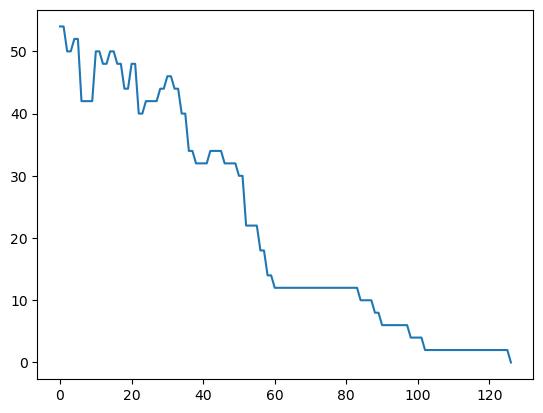

In [192]:
plt.plot(history)

In [23]:
s = random_init(1000, 32)
%time result, history = optimize(s, max_iters=1000, verbose=True, return_history=True)

Initial solution has 2754 violations
1) 2754 -> 2680
2) 2680 -> 2608
3) 2608 -> 2514
4) 2514 -> 2444
5) 2444 -> 2358
6) 2358 -> 2328
7) 2328 -> 2302
8) 2302 -> 2246
9) 2246 -> 2200
10) 2200 -> 2148
11) 2148 -> 2100
12) 2100 -> 2058
13) 2058 -> 2018
14) 2018 -> 1964
15) 1964 -> 1918
16) 1918 -> 1876
17) 1876 -> 1836
18) 1836 -> 1802
19) 1802 -> 1748
20) 1748 -> 1734
21) 1734 -> 1696
22) 1696 -> 1680
23) 1680 -> 1644
24) 1644 -> 1608
25) 1608 -> 1572
26) 1572 -> 1538
27) 1538 -> 1534
28) 1534 -> 1524
29) 1524 -> 1496
30) 1496 -> 1464
31) 1464 -> 1424
32) 1424 -> 1426
33) 1426 -> 1390
34) 1390 -> 1368
35) 1368 -> 1336
36) 1336 -> 1314
37) 1314 -> 1308
38) 1308 -> 1292
39) 1292 -> 1262
40) 1262 -> 1254
41) 1254 -> 1254
42) 1254 -> 1250
43) 1250 -> 1230
44) 1230 -> 1220
45) 1220 -> 1222
46) 1222 -> 1198
47) 1198 -> 1194
48) 1194 -> 1170
49) 1170 -> 1142
50) 1142 -> 1134
51) 1134 -> 1096
52) 1096 -> 1098
53) 1098 -> 1066
54) 1066 -> 1060
55) 1060 -> 1042
56) 1042 -> 1040
57) 1040 -> 1008
58)

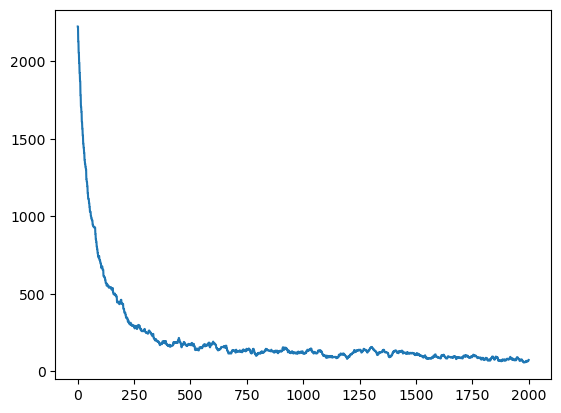

In [112]:
plt.plot(history)

In [114]:
s = random_init(1000, 24)
%time result, history = optimize(s, max_iters=1000, verbose=True, return_history=True)

Initial solution has 1476 violations
1) 1476 -> 1424
2) 1424 -> 1362
3) 1362 -> 1302
4) 1302 -> 1228
5) 1228 -> 1168
6) 1168 -> 1116
7) 1116 -> 1046
8) 1046 -> 1004
9) 1004 -> 974
10) 974 -> 966
11) 966 -> 924
12) 924 -> 880
13) 880 -> 844
14) 844 -> 832
15) 832 -> 802
16) 802 -> 752
17) 752 -> 730
18) 730 -> 696
19) 696 -> 688
20) 688 -> 674
21) 674 -> 650
22) 650 -> 646
23) 646 -> 626
24) 626 -> 614
25) 614 -> 594
26) 594 -> 606
27) 606 -> 584
28) 584 -> 558
29) 558 -> 532
30) 532 -> 518
31) 518 -> 492
32) 492 -> 466
33) 466 -> 448
34) 448 -> 440
35) 440 -> 428
36) 428 -> 412
37) 412 -> 410
38) 410 -> 388
39) 388 -> 368
40) 368 -> 336
41) 336 -> 322
42) 322 -> 300
43) 300 -> 304
44) 304 -> 306
45) 306 -> 314
46) 314 -> 284
47) 284 -> 260
48) 260 -> 244
49) 244 -> 244
50) 244 -> 242
51) 242 -> 234
52) 234 -> 222
53) 222 -> 224
54) 224 -> 222
55) 222 -> 210
56) 210 -> 192
57) 192 -> 186
58) 186 -> 182
59) 182 -> 172
60) 172 -> 166
61) 166 -> 154
62) 154 -> 148
63) 148 -> 138
64) 138 ->

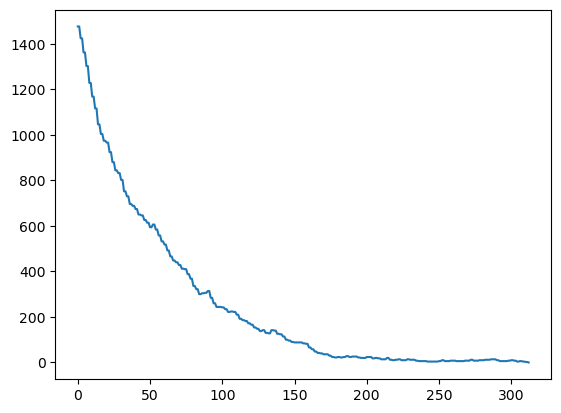

In [115]:
plt.plot(history)

In [226]:
s = init(2000, 32)

In [227]:
_, history = optimize(s, return_history=True, verbose=True, max_iters=1000)

Initial solution has 38 violations
1) 38 -> 36
2) 36 -> 30
3) 30 -> 30
4) 30 -> 32
5) 32 -> 28
6) 28 -> 24
7) 24 -> 20
8) 20 -> 18
9) 18 -> 16
10) 16 -> 16
11) 16 -> 18
12) 18 -> 22
13) 22 -> 16
14) 16 -> 14
15) 14 -> 14
16) 14 -> 18
17) 18 -> 16
18) 16 -> 12
19) 12 -> 12
20) 12 -> 12
21) 12 -> 14
22) 14 -> 18
23) 18 -> 22
24) 22 -> 20
25) 20 -> 22
26) 22 -> 22
27) 22 -> 24
28) 24 -> 26
29) 26 -> 20
30) 20 -> 20
31) 20 -> 18
32) 18 -> 18
33) 18 -> 18
34) 18 -> 14
35) 14 -> 8
36) 8 -> 10
37) 10 -> 8
38) 8 -> 10
39) 10 -> 10
40) 10 -> 10
41) 10 -> 8
42) 8 -> 8
43) 8 -> 12
44) 12 -> 18
45) 18 -> 14
46) 14 -> 18
47) 18 -> 20
48) 20 -> 12
49) 12 -> 14
50) 14 -> 10
51) 10 -> 12
52) 12 -> 14
53) 14 -> 14
54) 14 -> 16
55) 16 -> 10
56) 10 -> 10
57) 10 -> 10
58) 10 -> 12
59) 12 -> 14
60) 14 -> 16
61) 16 -> 22
62) 22 -> 22
63) 22 -> 22
64) 22 -> 22
65) 22 -> 24
66) 24 -> 30
Adding pool 63 to replicate 3
67) 30 -> 26
68) 26 -> 22
69) 22 -> 20
70) 20 -> 18
71) 18 -> 16
72) 16 -> 10
73) 10 -> 10
74)

In [229]:
len(history)

203

In [231]:
len(history)

203